# AI reading Wikipedia

- Date: 2019-03-14
- Source: Stanford NLP Group

## Setup

In [1]:
import datetime
import pandas as pd
import numpy as np
import requests
import datetime
import matplotlib.pyplot as plt
from src.plot import ds_plot

%config InlineBackend.figure_format = 'retina'
plt.style.use('../assets/datastory.mpltstyle')

## Load and transform

In [2]:
def get_squad_leaderboard(version):
    """Downloads and cleans up Squad leaderboard"""
    
    v1_url = ('https://raw.githubusercontent.com/'
          'rajpurkar/SQuAD-explorer/master/out-v1.1.json')

    v2_url = ('https://raw.githubusercontent.com/'
              'rajpurkar/SQuAD-explorer/master/out-v2.0.json')
    
    # Human performance scores
    hp_v1_f1 = 91.221
    hp_v1_em = 82.304
    hp_v2_f1 = 89.452
    hp_v2_em = 86.831

    def fix_paren_errors(row):
        """Dirty fix for model names with parenthesis"""
        if row['err'] is not np.nan:
            _type, team, err = row
            row['type'] = team
            row['team'] = err
            row['err'] = np.nan
        elif row['team'] is np.nan:
            _type, team, err = row
            row['type'] = np.nan
            row['err'] = np.nan
        return row

    def delete_model_and_team(row):
        text = row['description']
        model = row['type'] if row['type'] is not np.nan else ''
        team = row['team'] if row['team'] is not np.nan else ''
        url = row['url'] if row['url'] is not np.nan else ''
        text = text.replace(f'({model})', '')
        #text = text.replace(f'({team})', '')
        text = text.replace(url, '')
        text = text.strip()
        return text

    def extract_url(row):
        url = row['description'].split(' ')[-1]
        if not url.startswith('http'):
            url = np.nan
        return url

    url = v1_url if version == 1 else v2_url
    data = requests.get(url).json()
    data = data.get('leaderboard')

    scores = pd.DataFrame([x['scores'] for x in data])
    submissions = pd.DataFrame([x['submission'] for x in data])

    df = pd.concat([submissions, scores], axis=1)
    df['created'] = df['created'].apply(datetime.datetime.utcfromtimestamp).dt.date
    drops = ['num_period_submissions', 'num_total_submissions', 'user_name', 'public']
    df = df.drop(drops, axis=1)

    # Parse description field
    fields = df.description.str.extractall('\(([\w&\+, \-\.]*)\)')
    fields = fields.reset_index()
    fields.columns = ['row', 'match', 'val']
    fields = fields.pivot_table(index='row', values='val', columns='match', aggfunc=sum)
    fields.columns = ['type', 'team', 'err']
    fields = fields.apply(fix_paren_errors, axis=1)
    fields = fields.drop('err', axis=1)

    df = pd.merge(df, fields, left_index=True, right_index=True)
    df['url'] = df.apply(extract_url, axis=1)
    df.description = df.apply(delete_model_and_team, axis=1)
    df['type'] = df['type'].str.replace('model', '').str.strip()
    
    df = df.melt(id_vars=['created', 'description', 'type', 'team', 'url'],
        value_vars=['exact_match', 'f1'])
    
    f1 = f'Stanford Question Answering Dataset {version}.0 F1 test'
    em = f'Stanford Question Answering Dataset {version}.0 EM test'
    
    df['name_metric'] = df.variable.apply(lambda x: f1 if x == 'f1' else em)
    df['name_problem'] = 'Language comprehension and question-answering'
    renames = {'created': 'date', 'description': 'name_measure', 'url': 'url_measure'}
    df = df.rename(columns=renames)
    
    df['scale'] = 'Score'
    df['target'] = df.variable.apply(lambda x: hp_v1_f1 if x == 'f1' and version == 1 \
                                               else hp_v1_em if x == 'exact_match' and version == 1 \
                                               else hp_v2_f1 if x == 'f1' and version == 2 \
                                               else hp_v2_em)
    
    df = df.drop('variable', axis=1)
    df['name_measure'] = df.apply(lambda x: f'{x["name_measure"]} ({x["type"]})', axis=1)
    df = df.drop('type', axis=1)
    
    df['target_label'] = 'Human performance'
    df['target_source'] = 'https://rajpurkar.github.io/SQuAD-explorer/'
    df['url_metric'] = 'https://rajpurkar.github.io/SQuAD-explorer/'
    df['uncertainty'] = 0
    df['maxval'] = df['value']
    df['minval'] = df['value']
    df['offset'] = ''
    df['src_name'] = ''
    df['max_date'] = ''
    df['min_date'] = ''
    df['papername'] = ''
    df['label'] = df['name_measure']
    
    col_order = ['name_problem', 'name_metric', 'name_measure', 'papername',
                 'src_name', 'date', 'value', 'scale', 'target', 'target_label',
                 'label', 'maxval', 'minval', 'max_date', 'min_date', 'offset',
                 'target_source', 'uncertainty', 'url_measure', 'url_metric']
    
    return df[col_order]

In [3]:
v1 = get_squad_leaderboard(version=1)
v2 = get_squad_leaderboard(version=2)

In [4]:
v2 = v2.sort_values(by='date')
v2 = v2.dropna(subset=['value'])
v2['record'] = v2.value.cummax()
v2 = v2.drop_duplicates(subset='record')

In [5]:
v2['company'] = v2.name_measure.str.extract('(Google|Microsoft|Alibaba)').fillna('')

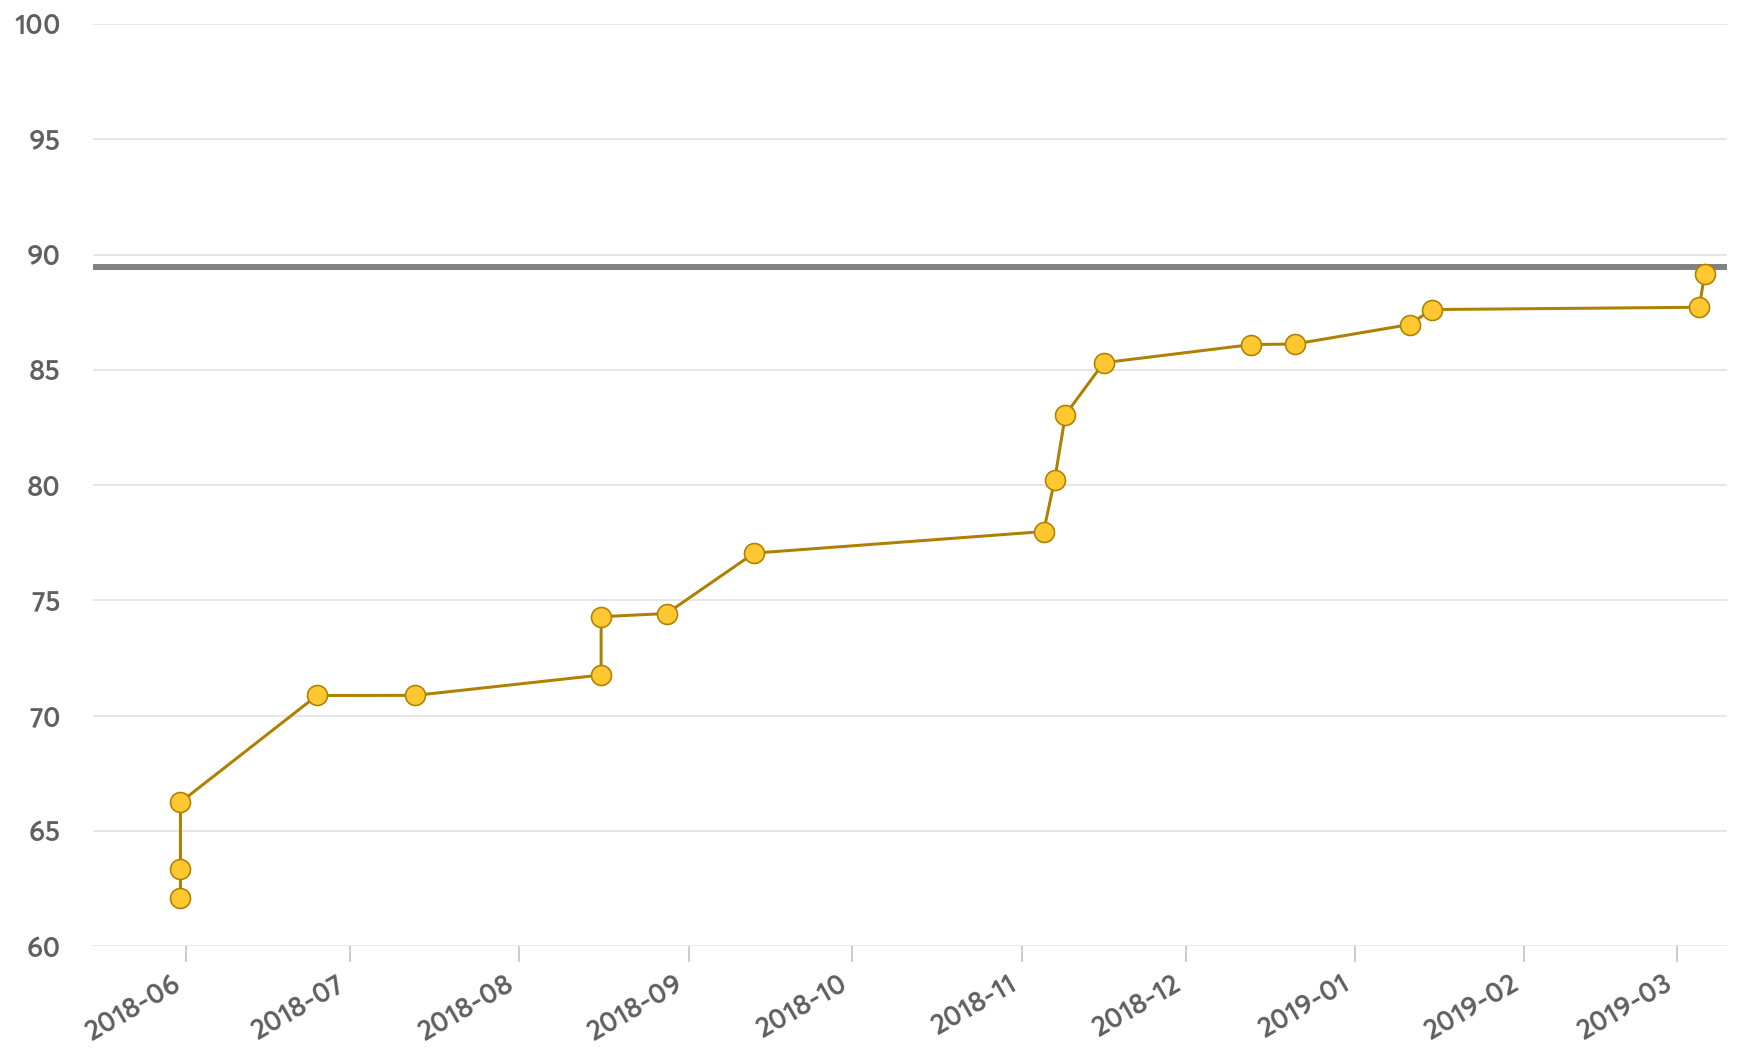

In [7]:
w = 12
h = w * 0.597
figsize = (w, h)

fig, ax = ds_plot(figsize=figsize)

fig.autofmt_xdate()

ax.axhline(v2.target.iloc[0], c='#818183', lw=3)

ax.plot(v2.date, v2.record, color='#af8000');
ax.plot(v2.date, v2.record, 'o', color='#ffc830', mec='#af8000', mew=0.8, ms=10);

ax.set_ylim(60, 100)
ax.set_xlim('2018-05-15', '2019-03-10')

#for i, x in v2.iterrows():
#    ax.text(x.date + datetime.timedelta(days=3), x.record, x.company,
#            ha='left', va='center', fontdict={'size': 14, 'weight': 500}, color='#606062')

plt.tight_layout(pad=0)
fig.savefig('../charts/squad.png')